In [6]:
%matplotlib inline
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import scipy
style.use('ggplot')
from datetime import datetime

sns.set_style('whitegrid')
sns.set_palette('colorblind')
FIG_SIZE = (12, 3)

font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 30}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['text.usetex'] = True

plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['axes.labelsize']= 22
plt.rcParams['lines.linewidth']= 2
plt.rcParams['lines.markersize']= 2

In [7]:
# Already prepared the data for the NPM_FINAL dataframe
#Filter: at least 700 days, github, 
npm_packages=pd.read_csv('../../popularity/csv/npm_popularity_2yearsOld.csv', sep=';', dtype=object, index_col='name')

npm_packages['first_release']=npm_packages['first_release'].apply(lambda x:
                                                                  float("".join(re.findall("[0-9.]+", x))) if 'day' in x 
                                                                  else float("".join(re.findall("[0-9.]+", x)))*30 if 'month' in x
                                                                  else (datetime.now().date() - 
                                                                        datetime.strptime(x, '%b %d, %Y').date()).days)

for x in npm_packages:
    #if x!= "first_release":
    npm_packages[x]=npm_packages[x].apply(float)
    npm_packages[x]=npm_packages[x].apply(float)
        

npm_packages.drop_duplicates(inplace=True)
npm_packages.drop('contributors', axis=1, inplace=True)

npm2=pd.read_csv('../../popularity/csv/only_npm.csv', sep=',', dtype=object, index_col=None)
npm2=npm2.loc[:,['Name','Repository URL']]
npm2=npm2.rename(columns = {'Name':'name','Repository URL':'url'})

npm2=npm2.set_index('name').merge(npm_packages,
                               left_index=True, 
                               right_index=True,
                               how='outer').dropna().reset_index()
npm2.dropna(inplace=True)

In [8]:
# remove duplicates, take only the popular ones with unique repository name
npm=npm2.sort_values('downloads', ascending=False)
npm['url']=npm['url'].apply(lambda x: x.split('/')[-2]+'-'+x.split('/')[-1])
npm=npm.groupby('url').first().reset_index()
npm.set_index('name', inplace=True)
npm.drop(['url','first_release','commits','dep_repo','dep_pro'], axis=1, inplace=True)
len(npm)

175774

In [9]:
### add more metrics from librariesio
librariesio=pd.read_csv('../../popularity/csv/popularity_deps.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)

npm=(npm.
     merge(librariesio.
           set_index('name'),
           left_index=True,
           right_index=True,
           how='left')
    )
len(npm)

175774

Text(0.5,0,'\\# dependencts From librariesio')

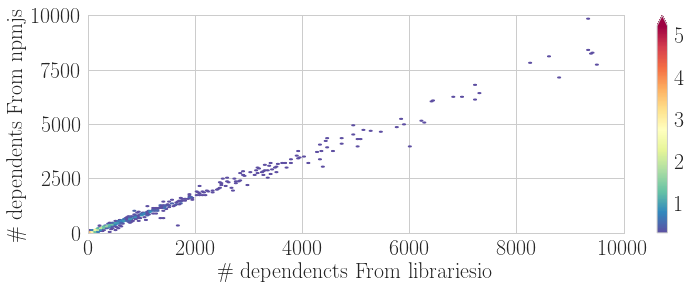

In [10]:
# Check if the metric of direct runtime dependents is npmjs.com is the same as in libraries.io
df_tmp=npm[['direct_runtime','dependents']].fillna(0)
for x in df_tmp:
    df_tmp[x]=df_tmp[x].apply(float)

color_map = plt.cm.Spectral_r
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
image = plt.hexbin(data=df_tmp, x='direct_runtime', y='dependents',cmap=color_map,gridsize=1000,mincnt=1,bins='log')
cb = plt.colorbar(image,spacing='uniform',extend='max')
ax.figure.set_size_inches(12,4)
ax.set_xlim(0,10000)
ax.set_ylim(0,10000)
ax.set_ylabel('\# dependents From npmjs')
ax.set_xlabel('\# dependencts From librariesio')

In [11]:
scipy.stats.pearsonr(df_tmp.direct_runtime,
                     df_tmp.dependents)

(0.99838874717083814, 0.0)

# Correlations between metrics from the same source

In [12]:
npm = npm[['forks','stars_github','pulls_issues','subscribers',
           'transitive_runtime','repo_runtime','direct_runtime',
           'downloads', 'stars_npm']]

In [13]:
npm=npm.fillna(0)

In [14]:
for x in npm:
    #if x!= "first_release":
    npm[x]=npm[x].apply(float)
    print(x,len(npm.query(str(x)+' == 0'))*100/len(npm))

forks 49.67515104622982
stars_github 31.993924016066085
pulls_issues 42.93922878241378
subscribers 5.121349004972294
transitive_runtime 72.94082173700319
repo_runtime 62.3323130838463
direct_runtime 27.38118265500017
downloads 0.01934302001433659
stars_npm 76.25644293240184


In [15]:
df_tmp=npm.loc[:,['transitive_runtime','repo_runtime','direct_runtime']]
for x in df_tmp:
    #if x!= "first_release":
    df_tmp[x]=df_tmp[x].apply(float)
df_tmp.corr(method="spearman").style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,transitive_runtime,repo_runtime,direct_runtime
transitive_runtime,1.0,0.63,0.66
repo_runtime,0.63,1.0,0.53
direct_runtime,0.66,0.53,1.0


In [16]:
df_tmp.corr(method="pearson").style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,transitive_runtime,repo_runtime,direct_runtime
transitive_runtime,1.0,0.58,0.62
repo_runtime,0.58,1.0,0.71
direct_runtime,0.62,0.71,1.0


In [17]:
df_tmp=npm.loc[:,['downloads','stars_npm','direct_runtime']]
for x in df_tmp:
    #if x!= "first_release":
    df_tmp[x]=df_tmp[x].apply(float)
df_tmp.corr(method="spearman").style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,downloads,stars_npm,direct_runtime
downloads,1.0,0.39,0.42
stars_npm,0.39,1.0,0.27
direct_runtime,0.42,0.27,1.0


In [18]:
df_tmp.corr(method="pearson").style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,downloads,stars_npm,direct_runtime
downloads,1.0,0.33,0.45
stars_npm,0.33,1.0,0.75
direct_runtime,0.45,0.75,1.0


In [19]:
df_tmp=npm.loc[:,['forks','stars_github','pulls_issues','subscribers']]
for x in df_tmp:
    #if x!= "first_release":
    df_tmp[x]=df_tmp[x].apply(float)
df_tmp.corr(method="spearman").style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,forks,stars_github,pulls_issues,subscribers
forks,1.0,0.73,0.7,0.55
stars_github,0.73,1.0,0.64,0.55
pulls_issues,0.7,0.64,1.0,0.53
subscribers,0.55,0.55,0.53,1.0


In [20]:
df_tmp.corr(method="pearson").style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,forks,stars_github,pulls_issues,subscribers
forks,1.0,0.85,0.63,0.68
stars_github,0.85,1.0,0.64,0.7
pulls_issues,0.63,0.64,1.0,0.51
subscribers,0.68,0.7,0.51,1.0


# Relating metrics emanating from the different sources

In [21]:
#npm['usage']=(npm['dep_pro'] + npm['dep_repo'])
npm['community_interest']=(npm['stars_github']+
                          npm['forks']+
                          (npm['pulls_issues']*npm['pulls_issues'])
                          )

In [28]:
corre = npm[['community_interest','subscribers',
          # 'transitive_runtime',
             'repo_runtime','direct_runtime',
           'downloads', 'stars_npm']]
corre.rename(columns={'community_interest':"Aggarwal-Pop", #"transitive_runtime":'transitive deps',
                     'direct_runtime':'runtime deps','stars_npm':'npm stars','repo_runtime':'deps repositories'},
            inplace=True)
ax = corre.corr(method="spearman").style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), 
                                                                             low=.09,high=.18, axis=1)
ax

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Aggarwal-Pop,subscribers,deps repositories,runtime deps,downloads,npm stars
Aggarwal-Pop,1.0,0.57,0.38,0.25,0.54,0.42
subscribers,0.57,1.0,0.28,0.19,0.37,0.3
deps repositories,0.38,0.28,1.0,0.53,0.51,0.34
runtime deps,0.25,0.19,0.53,1.0,0.42,0.27
downloads,0.54,0.37,0.51,0.42,1.0,0.39
npm stars,0.42,0.3,0.34,0.27,0.39,1.0


### Simulate a search in npmjs.com ans then check if the results are in the top 1000 in terms of other popularity metrics

In [27]:
npm_search=npm.dropna().reset_index()
for x in npm_search:
    if x!= "name":
        npm_search[x]=npm_search[x].apply(float)

In [28]:
# TOP 1000 DOWNLOADED
top=1000

npm_search.sort_values('downloads', inplace=True, ascending=False)
df_downloads=npm_search.head(top).loc[:,['name']]
df_downloads['type']='downloads'

# TOP 1000 STARRED
npm_search.sort_values('stars_npm', inplace=True, ascending=False)
df_stars=npm_search.head(top).loc[:,['name']]
df_stars['type']='stars npm'

# TOP 1000 SUBSCRIBED
npm_search.sort_values('subscribers', inplace=True, ascending=False)
df_subscribers=npm_search.head(top).loc[:,['name']]
df_subscribers['type']='subscribers'

# TOP 1000 COMMUNITY INTEREST

npm_search.sort_values('community_interest', inplace=True, ascending=False)
df_community=npm_search.head(top).loc[:,['name']]
df_community['type']='community interest'

# TOP 1000 transitive runtime
#npm_search.sort_values('transitive_runtime', inplace=True,ascending=False)
#df_transitive=npm_search.head(top).loc[:,['name']]
#df_transitive['type']='transitive runtime'

# TOP 1000 repo runtime
npm_search.sort_values('repo_runtime', inplace=True, ascending=False)
df_repo=npm_search.head(top).loc[:,['name']]
df_repo['type']='repo runtime'


df_all=pd.concat([df_downloads,df_stars,df_subscribers,df_community,
                  #df_transitive, 
                  df_repo])

In [29]:
# SEARCH IN NPMJS.COM
npm_search.sort_values('direct_runtime', inplace=True, ascending=False)
df_dependents=npm_search.head(top).loc[:,['name']]
df_dependents['top_dependent']='True'


df_all=df_all.set_index('name').merge(df_dependents.
                                      set_index('name'),
                                      left_index=True,
                                      right_index=True,
                                      how='outer').dropna().reset_index()
df_all.drop(['top_dependent'], axis=1, inplace=True)

In [30]:
lis=df_all.groupby('name')['type'].apply(list)
tab= [i for i in lis]
from pymining import seqmining 
freq_seqs = seqmining.freq_seq_enum(tab, 1)
#print("Seuls: ",sorted(freq_seqs))

# Venn diagram with 5 edges

In [31]:
# Venn diagram with 5 edges
number={}
number['community interest']=10000
number['downloads']=1000
number['stars npm']=100
number['subscribers']=10
number['repo runtime']=1

tabs={}
for x in freq_seqs:
    result=0
    for y in x[0]:
        result=result+number[y]
    result=str("%05d" % (result,))
    tabs[result]=x[1]

In [32]:
labels = ['00001','00010','00100','01000','10000']
for x in labels:
    print(tabs[x])

549
166
601
391
194


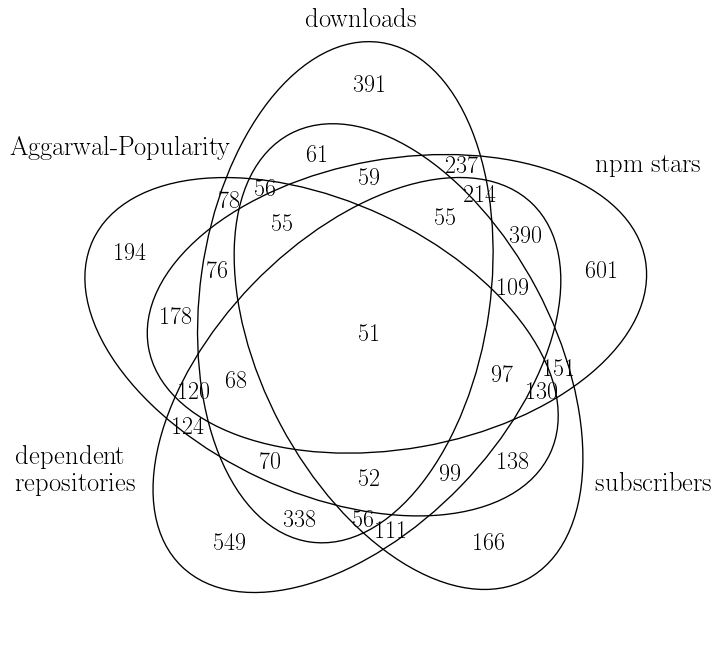

In [46]:
%matplotlib inline
#https://github.com/tctianchi/pyvenn
import venn
plt.rcParams['text.usetex'] = False
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)

plt.rcParams['text.usetex'] = True

fig, ax = venn.venn5(tabs)
ax.legend('')
fig.set_size_inches(8,8)
ax.text(0.4, 1, 'downloads', fontsize=20,  color='black')
ax.text(-0.11, 0.78, 'Aggarwal-Popularity', fontsize=20,  color='black')
ax.text(0.9, 0.75, 'npm stars', fontsize=20,  color='black')
ax.text(-0.1, 0.2, 'dependent\n repositories', fontsize=20,  color='black')
ax.text(0.9, 0.2, 'subscribers', fontsize=20,  color='black')
ax.figure.savefig('../../../seneca_research/npm_popularity/figures/venn_pop.pdf', bbox_inches='tight', facecolor='white')


# Venn diagram with 6 edges

In [81]:
# Venn diagram with 6 edges
number={}
number['community interest']=100000
number['downloads']=10000
number['stars npm']=1000
number['subscribers']=100
number['transitive runtime']=10
number['repo runtime']=1

tabs={}
for x in freq_seqs:
    result=0
    for y in x[0]:
        result=result+number[y]
    result=str("%06d" % (result,))
    tabs[result]=x[1]

In [ ]:
labels = ['000001','000010','000100','001000','010000','100000']
for x in labels:
    print(tabs[x])

In [ ]:
%matplotlib inline
#https://github.com/tctianchi/pyvenn
import venn
plt.rcParams['text.usetex'] = False
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)

plt.rcParams['text.usetex'] = True

#labels = venn.get_labels([range(10), range(5, 15), range(3, 8), range(8, 17), range(10, 20)], fill=['number', 'logic'])
fig, ax = venn.venn6(tabs, names=list(sorted(number.keys())))
ax.legend(bbox_to_anchor=(1, 0))
fig.set_size_inches(20,10)